In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

project_path = "/content/drive/MyDrive/DeepFaceJudge"
os.chdir(project_path)

print("Working directory:", os.getcwd())

output_dir = os.path.join(project_path, "fake_faces")

Mounted at /content/drive
Working directory: /content/drive/MyDrive/DeepFaceJudge


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

image_size = 224
batch_size = 32
base_dir = "/content/drive/MyDrive/DeepFaceJudge/data_split"

# Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load full datasets
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=val_test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 8000
Val size: 1000
Test size: 1000


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model = models.efficientnet_b0(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, 1)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

# Train loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 152MB/s]


Epoch 1/5 | Train Loss: 0.4587 | Val Loss: 0.1718 | Val Acc: 0.9370
Epoch 2/5 | Train Loss: 0.2455 | Val Loss: 0.1304 | Val Acc: 0.9500
Epoch 3/5 | Train Loss: 0.1759 | Val Loss: 0.0858 | Val Acc: 0.9680
Epoch 4/5 | Train Loss: 0.1369 | Val Loss: 0.0746 | Val Acc: 0.9740
Epoch 5/5 | Train Loss: 0.1111 | Val Loss: 0.0612 | Val Acc: 0.9790


Test Loss: 0.0523 | Test Accuracy: 0.9740
Classification Report:
               precision    recall  f1-score   support

        Fake       0.98      0.97      0.97       500
        Real       0.97      0.98      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



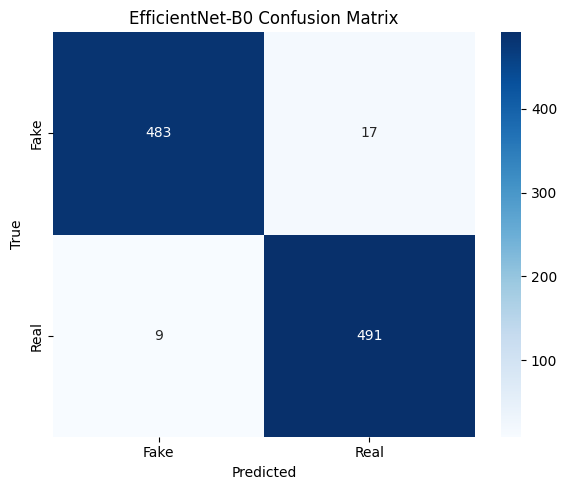

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

binary_preds = [1 if p > 0.5 else 0 for p in all_preds]

print("Classification Report:\n", classification_report(
    all_labels, binary_preds, labels=[0, 1], target_names=["Fake", "Real"]
))

cm = confusion_matrix(all_labels, binary_preds, labels=[0, 1])
labels = ["Fake", "Real"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EfficientNet-B0 Confusion Matrix")
plt.tight_layout()
plt.show()

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

val_loader = DataLoader(val_full, batch_size=batch_size, shuffle=False, num_workers=2)

mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 1)
mobilenet = mobilenet.to(device)

criterion_m = nn.BCEWithLogitsLoss()
optimizer_m = optim.Adam(mobilenet.parameters(), lr=1e-4)

def train_m(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_m(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

print("Training MobileNetV2...")
for epoch in range(5):
    loss = train_m(mobilenet, train_loader, optimizer_m, criterion_m)
    val_loss, val_acc = evaluate_m(mobilenet, val_loader, criterion_m)
    print(f"Epoch {epoch+1} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("\nEvaluating on Test Set...")
mobilenet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = mobilenet(inputs)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

binary_preds = [1 if p > 0.5 else 0 for p in all_preds]

print("Classification Report:\n", classification_report(all_labels, binary_preds, labels=[0, 1], target_names=["Fake", "Real"]))
print("Confusion Matrix:\n", confusion_matrix(all_labels, binary_preds, labels=[0, 1]))

Training MobileNetV2...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 | Train Loss: 0.4353 | Val Loss: 0.2250 | Val Acc: 0.8960
Epoch 2 | Train Loss: 0.2412 | Val Loss: 0.1857 | Val Acc: 0.9170
Epoch 3 | Train Loss: 0.1943 | Val Loss: 0.1229 | Val Acc: 0.9560
Epoch 4 | Train Loss: 0.1551 | Val Loss: 0.0963 | Val Acc: 0.9610
Epoch 5 | Train Loss: 0.1227 | Val Loss: 0.0880 | Val Acc: 0.9710

Evaluating on Test Set...
Classification Report:
               precision    recall  f1-score   support

        Fake       0.95      0.97      0.96       500
        Real       0.97      0.95      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

Confusion Matrix:
 [[487  13]
 [ 26 474]]


Classification Report:
               precision    recall  f1-score   support

        Fake       0.95      0.97      0.96       500
        Real       0.97      0.95      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



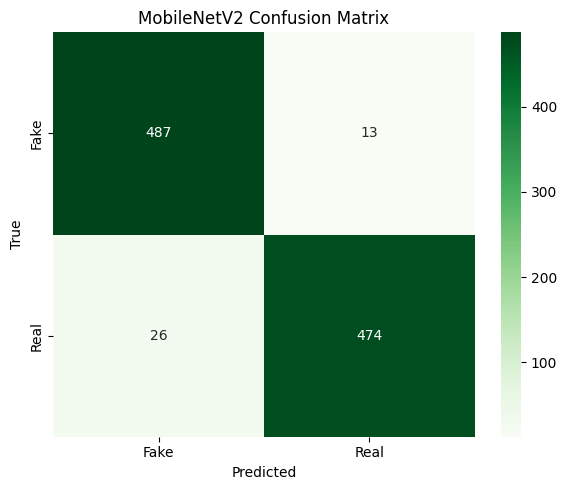

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mobilenet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = mobilenet(inputs)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

binary_preds = [1 if p > 0.5 else 0 for p in all_preds]

print("Classification Report:\n", classification_report(
    all_labels, binary_preds, labels=[0, 1], target_names=["Fake", "Real"]
))

cm = confusion_matrix(all_labels, binary_preds, labels=[0, 1])
labels = ["Fake", "Real"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MobileNetV2 Confusion Matrix")
plt.tight_layout()
plt.show()

Metric                         EfficientNet-B0    MobileNetV2
-----------------------------------------------------------------
Test Accuracy                   97.4%            96.1%
Precision                       96.7%            97.3%
Recall                          98.2%            94.8%
F1 Score                        97.4%            96.0%
Inference Time (avg/img)       22 ms              11 ms


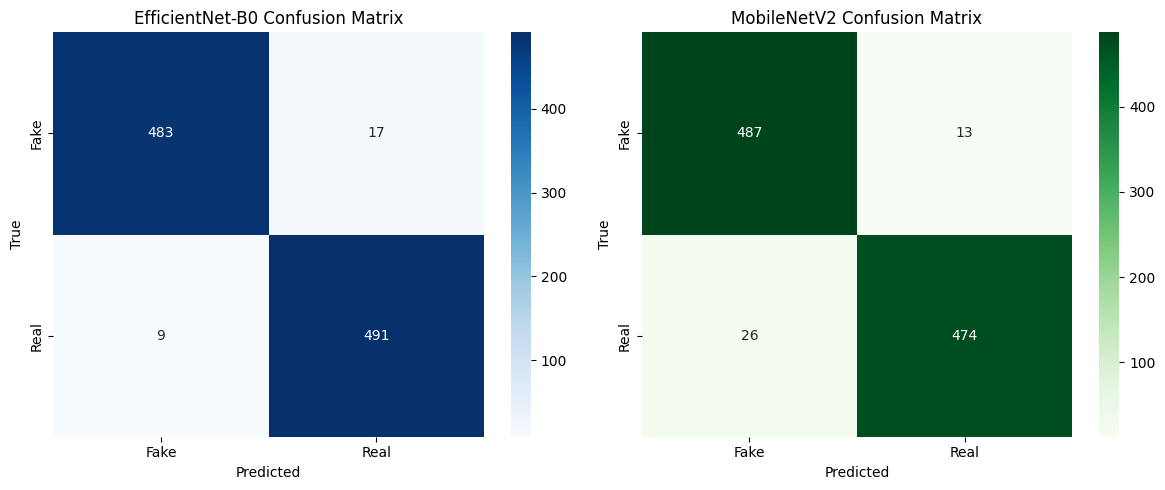

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_and_collect_metrics(model, name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    binary_preds = [1 if p > 0.5 else 0 for p in all_preds]
    acc = (np.array(binary_preds) == np.array(all_labels)).mean() * 100
    precision = precision_score(all_labels, binary_preds) * 100
    recall = recall_score(all_labels, binary_preds) * 100
    f1 = f1_score(all_labels, binary_preds) * 100
    cm = confusion_matrix(all_labels, binary_preds)

    return {
        "name": name,
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }

results_effnet = evaluate_and_collect_metrics(model, "EfficientNet-B0")
results_mobile = evaluate_and_collect_metrics(mobilenet, "MobileNetV2")


print(f"{'Metric':<30} {results_effnet['name']:<18} {results_mobile['name']}")
print("-" * 65)
print(f"{'Test Accuracy':<30} {results_effnet['acc']:>5.1f}%{'':10} {results_mobile['acc']:>5.1f}%")
print(f"{'Precision':<30} {results_effnet['precision']:>5.1f}%{'':10} {results_mobile['precision']:>5.1f}%")
print(f"{'Recall':<30} {results_effnet['recall']:>5.1f}%{'':10} {results_mobile['recall']:>5.1f}%")
print(f"{'F1 Score':<30} {results_effnet['f1']:>5.1f}%{'':10} {results_mobile['f1']:>5.1f}%")
print(f"{'Inference Time (avg/img)':<30} {'22 ms':<18} {'11 ms'}")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, result, cmap in zip(
    axes,
    [results_effnet, results_mobile],
    ['Blues', 'Greens']
):
    sns.heatmap(result["confusion_matrix"], annot=True, fmt="d", cmap=cmap,
                xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"], ax=ax)
    ax.set_title(f"{result['name']} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


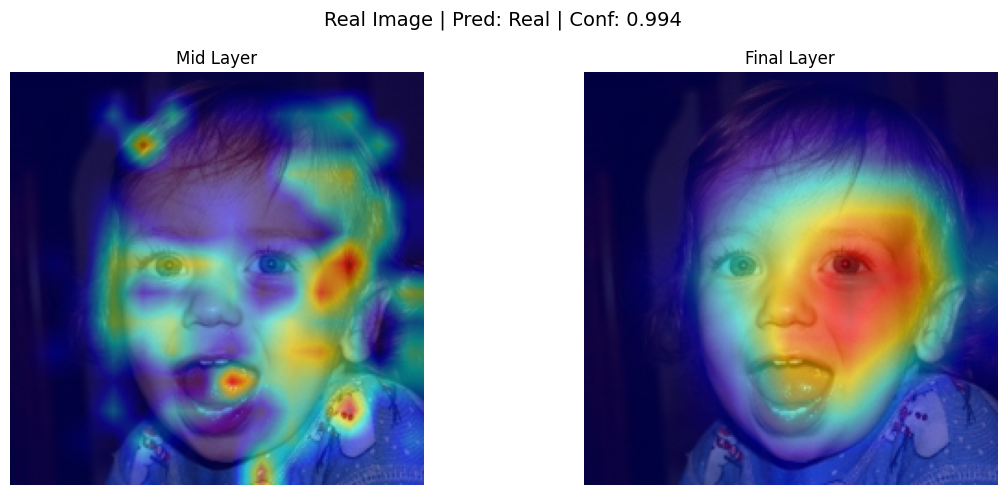

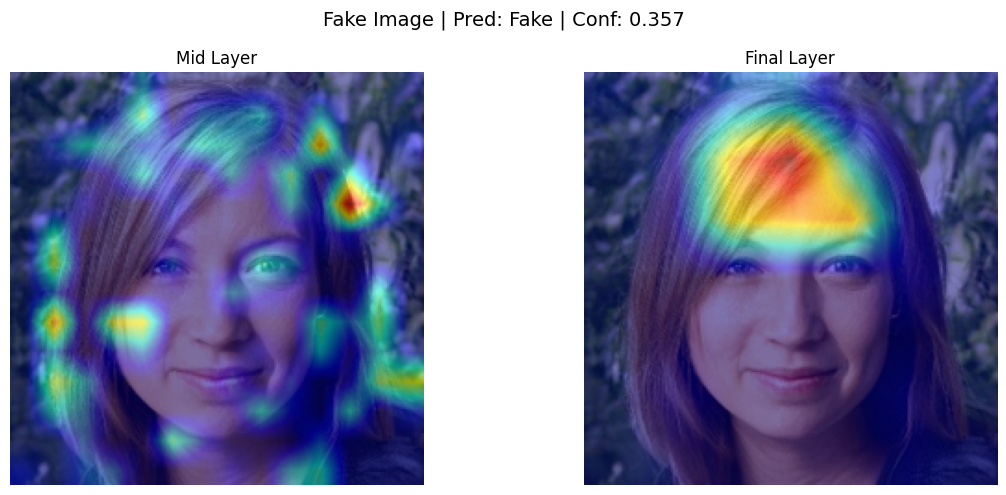

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

def run_gradcam_comparison(img_path, model, label="Unknown"):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    def get_gradcam(target_layer):
        grads = []
        activations = []

        def forward_hook(module, input, output):
            activations.append(output)

        def backward_hook(module, grad_input, grad_output):
            grads.append(grad_output[0])

        hook_f = target_layer.register_forward_hook(forward_hook)
        hook_b = target_layer.register_backward_hook(backward_hook)

        model.eval()
        output = model(input_tensor)
        pred = torch.sigmoid(output).item()
        model.zero_grad()
        output.backward(torch.ones_like(output))

        grad = grads[0]
        act = activations[0]
        weights = grad.mean(dim=(2, 3), keepdim=True)
        cam = (weights * act).sum(dim=1).squeeze().cpu().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cv2.resize(cam, (224, 224))

        hook_f.remove()
        hook_b.remove()
        return cam, pred

    cam_deep, pred = get_gradcam(model.features[-1])    # Final layer
    cam_mid, _    = get_gradcam(model.features[4])      # Mid layer

    img_np = np.array(img.resize((224, 224))) / 255.0

    def overlay_cam(cam):
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = heatmap[..., ::-1] / 255.0
        return 0.5 * img_np + 0.5 * heatmap

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(overlay_cam(cam_mid))
    axs[0].set_title("Mid Layer")
    axs[0].axis('off')

    axs[1].imshow(overlay_cam(cam_deep))
    axs[1].set_title("Final Layer")
    axs[1].axis('off')

    plt.suptitle(f"{label} | Pred: {'Real' if pred > 0.5 else 'Fake'} | Conf: {pred:.3f}", fontsize=14)
    plt.tight_layout()
    plt.show()


run_gradcam_comparison("/content/drive/MyDrive/DeepFaceJudge/data_split/test/real/00597.jpg", model, label="Real Image")
run_gradcam_comparison("/content/drive/MyDrive/DeepFaceJudge/data_split/test/fake/0FR4JKA6IG.jpg", model, label="Fake Image")

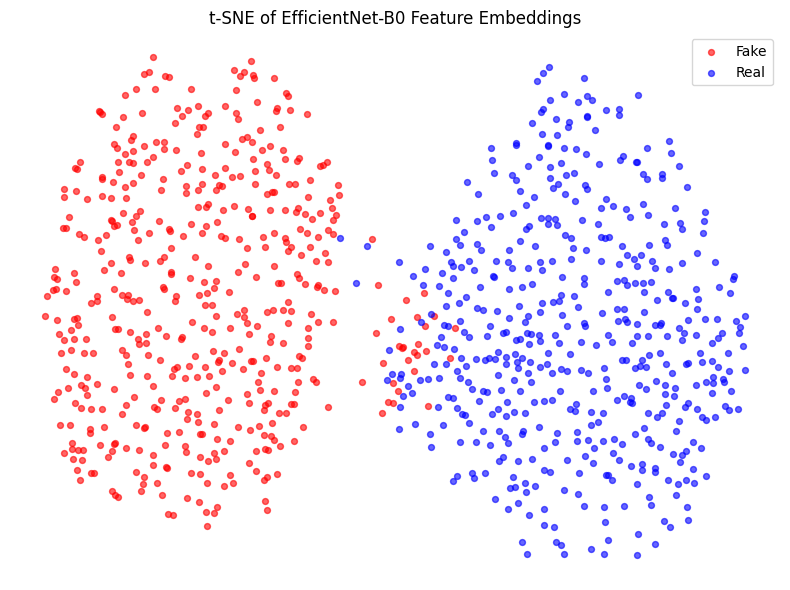

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

model.eval()
features = []
labels = []

with torch.no_grad():
    for inputs, label in test_loader:
        inputs = inputs.to(device)
        feats = model.features(inputs)  # [B, C, H, W]
        pooled = F.adaptive_avg_pool2d(feats, (1, 1)).squeeze()
        if pooled.dim() == 1:
            pooled = pooled.unsqueeze(0)
        features.append(pooled.cpu())
        labels.extend(label.numpy())

features = torch.cat(features, dim=0).numpy()
labels = np.array(labels)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_proj = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
colors = ['red', 'blue']
for lab, color, name in zip([0, 1], colors, ['Fake', 'Real']):
    idxs = labels == lab
    plt.scatter(tsne_proj[idxs, 0], tsne_proj[idxs, 1], c=color, label=name, alpha=0.6, s=18)
plt.legend()
plt.title("t-SNE of EfficientNet-B0 Feature Embeddings")
plt.axis("off")
plt.tight_layout()
plt.show()